### Failure-Aware KE
Inspired by https://github.com/JohnDickerson/KidneyExchange.git

- Implemented:
    -  Model with Gurobi MIP Solver, small examples passed, i.e. same with JohnDickerson's implementation.

- Ready to Work:
    - Branch-and-Price
    
- Not (going to be) Implemented:
    - InfiniteTailUtility 

## TODO:
FAIL OR SUCC PROB???

#### imports

In [420]:
import json
import random
import networkx as nx
from typing import List, Tuple, Dict, Set
from matplotlib import pyplot as plt
from gurobi import *
import copy

\ Model ModelX

\ LP format - for model browsing. Use MPS format to capture full model detail.

Minimize

 

Subject To

 row0: <= 1

 row_a: <= 2.1

 row_b: <= 2

 row1: x <= 5

 row2: 3 x <= 2.1

Bounds

End

\ Model ModelX

\ LP format - for model browsing. Use MPS format to capture full model detail.

Minimize

  2 x

Subject To

 row_a: <= 2.1

 row_b: <= 2

 row1: x <= 5

 row2: 3 x <= 2.1

Bounds

End

\ Model ModelX

\ LP format - for model browsing. Use MPS format to capture full model detail.

Minimize

  2 x

Subject To

 row_a: <= 2.1

 row_b: <= 2

 row1: x + 2.4 y <= 5

 row2: 3 x + 2.2 y <= 2.1

Bounds

End

\ Model ModelX

\ LP format - for model browsing. Use MPS format to capture full model detail.

Minimize

 

Subject To

 row_a: <= 2.1

 row_b: <= 2

 row1: 2.4 y <= 5

 row2: 2.2 y <= 2.1

Bounds

End

y = 0.0
0.0
[('row1', 0.0), ('row2', 0.0)]
bnp-solve:  2.0
4
4
mip-solve: 2.0


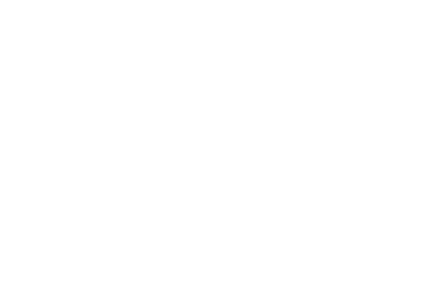

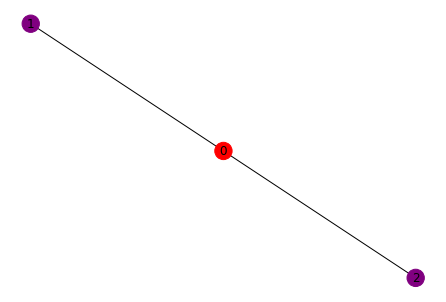

In [421]:
%run pyBnPLib.ipynb

#### utils

In [422]:
def _printLP(m):
    m.write('tmp.lp')
    f = open('tmp.lp', 'r')
    for l in f.readlines():
        print(l)
    print('====================')

#### Matching Pool Class

In [423]:
class Graph:
    def __init__(self, usingFailProb=True):
        self.g = nx.DiGraph()
        self.pairs = set()
        self.altruists = set()
        self.usingFailProb = usingFailProb
        
        
    def addV(self, vid:int, isPair=True):
        if isPair:
            self.pairs.add(vid)
            self.g.add_node(vid, Type='Pair')
        else:
            self.altruists.add(vid)
            self.g.add_node(vid, Type='Altruist')
            
            
    def addE(self, source:int, target:int, prob=1.0):
        self.g.add_edge(source, target, prob=prob)
        
        
    def isChain(self, obj: List[int]):
        return obj[0] in self.altruists
    
    
    def saveAsFile(self, filename: str):
        pairs = list(self.pairs)
        altruists = list(self.altruists)
        
        edges = [[s,t,p] for s,t,p in self.g.edges.data('prob')]
        
        graphJson = json.dumps({"pairs": pairs, "altruists":altruists, "edges": edges})
        with open(filename, 'w') as f:
            f.write(graphJson)  
            
            
    def weighAnEdge(self, edge:Tuple[int, int]) -> float:
        return 1.0
    
    
    def weighDummyEdge(self, edge:Tuple[int, int]) -> float:
        return 1.0
    
    
    def failProbOfEdge(self, edge:Tuple[int, int]) -> float:
        return self.g.get_edge_data(edge[0], edge[1])['prob']


    def weighACycle(self, cycle:List[int]) -> float:
        startE = (cycle[0],cycle[1])
        pathWeight = 0
        pathSuccProb = 1
        pathWeight *= pathSuccProb
        for source, target in zip(cycle, cycle[1:]+[cycle[0]]):
            E = (source, target)
            pathWeight += self.weighAnEdge(E)
            pathSuccProb *= (1.0 - self.failProbOfEdge(E))

        if self.usingFailProb:
            return pathWeight * pathSuccProb
        else:
            return pathWeight
    

    def weighAChain(self, chain:List[int]) -> float:
        discountedPathWeight = 0.0
        rawPathWeight = 0
        pathSuccProb = 1
        
        for source, target in zip(chain[:-1], chain[1:]):
            E = (source, target)
            discountedPathWeight += rawPathWeight * pathSuccProb * self.failProbOfEdge(E)
            rawPathWeight += self.weighAnEdge(E)
            pathSuccProb *= (1 - self.failProbOfEdge(E))
            
            
        # DUMMY EDGE WEIGHT
        dummyEdgeWeight = self.weighDummyEdge((chain[-1], chain[0]))
        
        if self.usingFailProb:
#             print(discountedPathWeight, rawPathWeight , pathSuccProb)
            return discountedPathWeight + (rawPathWeight * pathSuccProb) + dummyEdgeWeight 
        else:
            return rawPathWeight + dummyEdgeWeight
            
    
    


#### Helper of Pool Class

In [424]:
def buildGraphFromRaw(pairs:List[int], altruists:List[int], 
                   edges_with_prob:List[Tuple[int, int, float]]) -> Graph:
    self = Graph()
    for v in pairs:
        self.addV(v, isPair=True)
    for v in altruists:
        self.addV(v, isPair=False)
    for s,t,p in edges_with_prob:
        self.addE(s, t, p)
    return self


def noDummy2withDummy(graph:Graph) -> Graph:
    newGraph = copy.deepcopy(graph)
    for nid in graph.pairs:
        for al in graph.altruists:
            newGraph.addE(nid, al, 1.0)
    return newGraph


def generateRandomGraph(N:int, M:int, with_dummy=True, failProb=0.0) -> Graph:
    pairs = [0, 1, 2, 3]
    altruists = [4, 5]
#     altruists = []
    
    prob = failProb

    edges = set([(0, 1), (1, 2), (1, 3), (2, 1), (2, 0), (3, 2), (4, 3)])

    for nid in range(len(pairs)+len(altruists), N):
        pairs.append(nid)

    oldM = len(edges)
    for m in range(M - oldM):
        s = random.randint(0, N-1)
        t = random.randint(0, N-1)
        if t not in altruists and s != t:
            edges.add( (s, t) )

    edges_with_prob = [(s, t, prob) for s,t in edges]
    
    graph = buildGraphFromRaw(pairs, altruists, edges_with_prob)
    if with_dummy:
        return noDummy2withDummy(graph)
    else:
        return graph

    
    
def buildGraphFromFile(filename: str) -> Graph:
    self = Graph()
    with open(filename) as f:
        graph = json.load(f)
        pairs = graph["pairs"]
        altruists = graph["altruists"]
        edges_with_prob = list(map(tuple, graph["edges"]))
        
        return buildGraphFromRaw(pairs, altruists, edges_with_prob)

    
def drawG(graph, sol:List[List[int]]=[]):
    if len(graph.nodes) > 50:
        print('too big graph, no show')
        return
    gx = nx.DiGraph()
    gx.add_nodes_from(list(range(len(graph.nodes))))
    for s,t in graph.edges:
        gx.add_edge(s,t)
    colors = ['red', 'purple', 'yellow', 'blue', 'green', 'orange', 'black']
    colorMap = ['gray'] * len(graph.nodes)
    i = 0
    for c in sol:
        color = colors[i%len(colors)]
        for n in c:
            colorMap[n] = color
        i += 1
        
#     print(gx.nodes)
        
    nx.draw(gx, pos=nx.spring_layout(gx), node_color = colorMap)

#### Cycle/Chain Generators

In [425]:

def genCyclesOfANode(graph: Graph, node: int, length:int, only_source=False) -> Tuple[List[List[int]], List[float]]:
    visited = set()
    def genNext(cur: int, rest: int) -> List[List[int]]:
        res = []
        visited.add(cur)
        if rest == 2:
            if node in graph.g.adj[cur]:
                res.append([cur])
        else:        
            for nxt in graph.g.adj[cur]:
                if only_source and nxt < node or nxt in visited or nxt in graph.altruists:
                    continue
                for r in genNext(nxt, rest-1):
                    r.append(cur)
                    res.append(r)
        visited.remove(cur)
        return res
    ans = [l[::-1] for l in genNext(node, length+1)]
    return ans, [graph.weighACycle(x) for x in ans]


def genChainsOfANode(graph: Graph, node: int, length: int) -> Tuple[List[List[int]], List[float]]:
    visited = set()
    def genNext(cur: int, rest:int) -> List[List[int]]:
        res = []
        visited.add(cur)
        if rest == 1:
            return [[cur]]
        else:
            for nxt in graph.g.adj[cur]:
                if nxt in visited or nxt in graph.altruists:
                    continue
                for r in genNext(nxt, rest-1):
                    r.append(cur)
                    res.append(r)
        visited.remove(cur)
        return res
    ans = [l[::-1] for l in genNext(node, length)]
    return ans, [graph.weighAChain(x) for x in ans]
                                            

    
def genAllCycles(graph: Graph, cycleCap: int) -> Tuple[List[List[int]], List[float]]:
    res1 = []
    res2 = []
    for pair in graph.pairs:
        for l in range(2, cycleCap+1):
            r, w = genCyclesOfANode(graph, pair, l, True)
            res1 += r
            res2 += w
    return res1, res2


def genAllChains(graph: Graph, chainCap: int) -> Tuple[List[List[int]], List[float]]:
    res1 = []
    res2 = []
    for altruist in graph.altruists:
        for l in range(2, chainCap+2):
            r, w = genChainsOfANode(graph, altruist, l)
            res1 += r
            res2 += w
    return res1, res2
        
        
def genAllCyclesAndChains(graph: Graph, cycleCap: int, chainCap: int) -> Tuple[List[List[int]], List[float]]:
    res1, res2 = genAllCycles(graph, cycleCap)
    r1, r2 = genAllChains(graph, chainCap) 
    res1 += r1
    res2 += r2
    return res1, res2





#### Gurobi MIP Solver

In [426]:
    
def simpleSolve(graph: Graph,  cycleCap: int, chainCap: int, INT=True):
    model = Model()
    model.setParam("OutputFlag", False)
    model.setObjective(0, sense=GRB.MAXIMIZE)
#     c2var = {}
    
    varsOfRow = {}
    for n in graph.pairs:
        varsOfRow[n] = []
    for n in graph.altruists:
        varsOfRow[n] = []
        
    VTYPE = GRB.INTEGER if INT else GRB.CONTINUOUS
    
    
    cycles, weights = genAllCycles(graph, cycleCap)
    for cycle, weight in zip(cycles, weights):
        vname = 'X_{}'.format(cycle)
        var = model.addVar(name=vname, obj=weight, vtype=VTYPE)
#         c2var[tuple(cycle)] = var
        for n in cycle:
            varsOfRow[n].append(var)
        
    
    chains, weights = genAllChains(graph, chainCap)
    for chain, weight in zip(chains, weights):
        vname = 'Y_{}'.format(chain)
        var = model.addVar(name=vname, obj=weight, vtype=VTYPE)
#         c2var[tuple(chain)] = var
        for n in chain:
            varsOfRow[n].append(var)
        
    model.update()
        
    for r in varsOfRow:
        model.addConstr( quicksum((var for var in varsOfRow[r])) <= 1, name='R{}'.format(r))
    
 
    model.optimize()
    return model

        

## Branch-And-Price

### Off-hand Branching Rule
#### For some frac col, find an edge whose source is also included in other frac cols, 
- Either that edge must included, or 
- Cannot be included

#### TODO:
- Check correctness of branching
- Currently first generated all cycles/chains. We need to do that incrementally

#### Helper

In [427]:
# data = (cycleCap, chainCap, graph, cycles, cycleWeights)
class KDEHelper(AbstractHelper):
    def __init__(self, data):
        super().__init__(data)
        cycleCap, chainCap, graph, cycles, cycleWeights = self.data
        self.c_weights = {}
        for c, w in zip(cycles, cycleWeights):
            self.c_weights[tuple(c)] = w
            
        
    def nameOfCol(self, sth:List[int])->str:
        
        if not graph.isChain(sth):
            return 'X' + str(sth)
        else:
            return 'Y' + str(sth)
        
        
    def colOfName(self, name:str)->List[int]:
        return eval(name[1:])
    
    
    def colCoes(self, sth:List[int])->Tuple[List[int], List[float]]:
        rows = []
        rowCoes = []
        for v in sth:
            rows.append(v)
            rowCoes.append(1)
        return rows, rowCoes
            
    
    def objOfCol(self, sth:List[int])->float:
        return self.c_weights[tuple(sth)]

    
    def nameOfRow(self, sth:int)->str:
        return "V"+str(sth)
    
    
    def rowOfName(self, name:str):
        return int(name[1:])
    
    
    # branch: same, node_i, node_j
    def nameOfBranch(self, sth:Tuple[bool, int, int])->str:
        return str(sth)
    
    
    def branchOfName(self, name:str):
        if name == 'ROOT':
            return None
        return eval(name)

#### Master

In [472]:
# data = (cycleCap, chainCap, graph, cycles, cycleWeights)
class KDEMaster(AbstractMaster):
    def cutCoes(self, sth)->Tuple[List, List[float], float]:
        pass
    
    
    def provideRHS(self, sth:str)->float:
        return 1
    
    
    def provideInitRows(self)->List[int]:
        cycleCap, chainCap, graph, cycles, cycleWeights = self.data
        return list(graph.g.nodes())
    
    
    def provideInitCols(self)->List[List[int]]:
        cycleCap, chainCap, graph, cycles, cycleWeights = self.data
        return [cycles[0]]
        
        
    def onBranchPerformed(self, node:Type[BnBTreeNode]):
        cycleCap, chainCap, graph, cycles, cycleWeights = self.data
        
        self.branch2actions[node.nid] = []
        branchDecisionSth = self.branchOfName(node.decision)
        if branchDecisionSth is None:
            return
        same, node_s, node_t = branchDecisionSth
        
        for vname in self.model.getCols():
            c = self.colOfName(vname)
            
            flag = False
            
            if not same:
                nc = zip(c[:-1], c[1:]) if graph.isChain(c) else zip(c, c[1:]+[c[0]])
                for x, y in nc:
                    if node_s == x and node_t == y:
                        flag = True
                        break
            else:
                nc = zip(c[:-1], c[1:]) if graph.isChain(c) else zip(c, c[1:]+[c[0]])
                for x, y in nc:
                    if node_s == x and node_t != y:
                        flag = True
                        break
                        
            if flag:
#                 print(vname, 'remove')
                self.model.removeColByName(vname)
                self.branch2actions[node.nid].append(('delCol', c))
    
    
    def onBranchReverted(self, node:Type[BnBTreeNode]): 
        for action, col in self.branch2actions[node.nid]:
            if action == 'delCol':
#                 print(col, 'readd')
                self.add_col(col)
        self.branch2actions.pop(node.nid)
        

    def branchGenerator(self)->List[Tuple[bool, int, int]]:
        frac_cols = []
        for c,v in self.model.getSol():
            if abs(math.ceil(v) - v) + abs(math.floor(v)-v) > EPS:
                frac_cols.append(self.colOfName(c))
                
        outs = {}
        for c in frac_cols:
            nc = zip(c[:-1], c[1:]) if graph.isChain(c) else zip(c, c[1:]+[c[0]])
            for x, y in nc:
                if x not in outs:
                    outs[x] = y
                if y != outs[x]:
                    return [(True, x, y), (False, x, y)]
        return []


#### Pricing

In [429]:
# data = (cycleCap, chainCap, graph, cycles, cycleWeights)
class KDEPricing(AbstractPricing):
    def build(self):
        cycleCap, chainCap, graph, cycles, cycleWeights = self.data
        self.nodePrice = [-1] * len(graph.g.nodes)
        self.rules = set()
        
    
    def updateByDual(self, sths:List[int], duals:List[float]):
        for n, p in zip(sths, duals):
            self.nodePrice[n] = p
    
    
    def fitRules(self, c):
        cycleCap, chainCap, graph, cycles, cycleWeights = self.data
        g = nx.DiGraph()
        nc = zip(c[:-1], c[1:]) if graph.isChain(c) else zip(c, c[1:]+[c[0]])
        for x, y in nc:
            g.add_edge(x, y)
        for same, s, t in self.rules:
            if same:
                if s in g.nodes and t not in g.adj[s]:
                    return False
            else:
                if s in g.nodes and t in g.adj[s]:
                    return False
        return True
        
    
    # return a col object or None
    def genAColAndReturn(self)->List[int]:
        cycleCap, chainCap, graph, cycles, cycleWeights = self.data
        mS = 0
        mC = None
        for c, w in zip(cycles, cycleWeights):
            s = sum([self.nodePrice[n] for n in c])
            if s + EPS < w:
                if self.fitRules(c):
                    mS = max(s, mS)
                    mC = c
        return mC
                
        
    def onBranchPerformed(self, node:Type[BnBTreeNode]):
        self.branch2actions[node.nid] = []
        
        branchDecisionSth = self.branchOfName(node.decision)
        if branchDecisionSth is None:
            return
        same, node_i, node_j = branchDecisionSth
        
        self.rules.add( (same, node_i, node_j) )
        self.branch2actions[node.nid].append( ('addRule', (same, node_i, node_j)) )
    
    
    def onBranchReverted(self, node:Type[BnBTreeNode]):
        for action, item in self.branch2actions[node.nid]:
            if action == 'addRule':
                self.rules.remove(item)
        self.branch2actions.pop(node.nid)
        
        
    def printProgram(self):
        print(rules)
        
        
    def printSolution(self):
        pass
    

#### Solve

In [470]:
def solveKDE(graph, cycleCap, chainCap):
    
    cycles, cycleWeights = genAllCyclesAndChains(graph, cycleCap, chainCap)
    
    print('prepared')
    
    data = (cycleCap, chainCap, graph, cycles, cycleWeights)
    
    KDEBnP = BnP(name="KDE", data=data, modelClass=GurobiModel, 
                 modelSense=ModelSense.MAX,
                masterClass=KDEMaster, pricingClass=KDEPricing, helperClass=KDEHelper,
                muteColGened=True, muteBranchBegin=True, muteBranchSolved=True, muteNewBranchAdded=True)
    
    KDEBnP.branchAndPrice()
    KDEBnP.drawBnPTree()
    
#     KDEBnP.master.model.printProgram()
    
    helper = KDEHelper(data)
    
    count = 3
    
    for n in KDEBnP.nodes:
        if n.status==NodeStatus.GLOBAL_OPT:
            sol = []
            print('bnp-solve: ', n.bound) # n.solution)
            for x, v in n.solution:
                if v > 0:
                    print(x, v)
                    sol.append( helper.colOfName(x) )
            if count > 0:
                plt.figure()
                drawG(graph.g, sol)
                count -= 1
            print()
    
    return KDEBnP


### Free Tests

In [431]:
N = 10
M = 10
fn = "./KidneyExchange-master/test_graph.json"

graph = generateRandomGraph(N, M, with_dummy=False)

In [432]:
graph = buildGraphFromRaw([0,1,2,3,5], [4, 6], 
                          [(0, 1, 1.0), (1, 2, 1.0), (1, 3, 1.0), (2, 3, 1.0), (2, 5, 1.0), (3, 2, 1.0), (4, 2, 1.0), (6, 3, 1.0)])


In [433]:
graph = buildGraphFromRaw([0,1,2,3], [4], 
                          [(0, 1, 0.0),(1, 0, 0.0), 
                           (1, 2, 0.0), (1, 3, 0.0),
                           (2, 1, 0.0), (2, 0, 0.0), (3, 2, 0.0), (4, 3, 0.0)])


In [434]:
# graph = buildGraphFromRaw([0, 1,2,3, 4, 5, 6, 7], [0], 
#                           [(1, 2, 0.0), (2, 5, 0.0), (5, 1, 0.0), 
#                           (2, 3, 0.0), (3, 6, 0.0), (6, 2, 0.0), 
#                           (3, 4, 0.0), (4, 7, 0.0), (7, 3, 0.0)])

In [435]:
# graph = buildGraphFromRaw([0,1,2,3], [4], 
#                           [(4, 1, 0.7), (1, 2, 0.7), (2, 3, 0.2), (2, 3, 1.0)])


In [436]:
graph.saveAsFile(fn)

In [437]:
graph = buildGraphFromFile(fn)

In [438]:
noDummy2withDummy(graph).saveAsFile(fn)

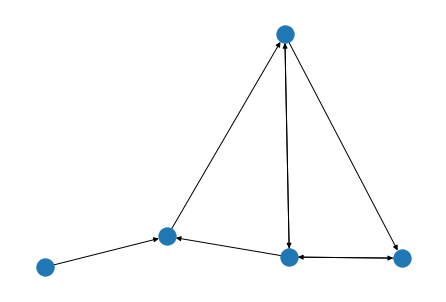

In [439]:
nx.draw(graph.g, pos=nx.spring_layout(graph.g), with_label=True)
# graph.g.add_edge(4, 9, prob=1.0)
# graph.g.edges()

In [440]:
# graph = Graph()
# graph.addV(0)
# graph.addV(1)
# graph.addV(2)
# graph.addV(3)
# graph.addV(4)
# graph.addV(5)
# edges = [(0,1), (1,2), (2,3), (2,0), (2,3), (3,0),
#          (3,4), (4,5), (5,0), (0,3), (3, 2), (0,2), (3, 1)]
# for s,t in edges:
#     graph.addE(s,t)
    
# genCycle(graph, 3, 3, False)


In [479]:
N = 500
M = int(N * N * 0.025)

graph = generateRandomGraph(N, M, with_dummy=False)

In [480]:
m = simpleSolve(graph, 3, 3, INT=True)

# _printLP(m)
sol = []
print('obj',m.objVal)
for v in m.getVars():
    if v.X != 0:
        sol.append( eval(v.varName[2:]) )
        print(v.varname, v.X)
drawG(graph.g, sol)

obj 428.0
X_[0, 83, 331] 1.0
X_[1, 240, 209] 1.0
X_[2, 493, 198] 1.0
X_[6, 69, 421] 1.0
X_[8, 430, 186] 1.0
X_[9, 382, 93] 1.0
X_[12, 348, 262] 1.0
X_[14, 355, 279] 1.0
X_[15, 352, 65] 1.0
X_[18, 381, 305] 1.0
X_[19, 141, 187] 1.0
X_[20, 441, 291] 1.0
X_[22, 54, 363] 1.0
X_[24, 148, 31] 1.0
X_[25, 78, 139] 1.0
X_[26, 426, 455] 1.0
X_[27, 491, 103] 1.0
X_[28, 346, 402] 1.0
X_[29, 44] 1.0
X_[30, 387, 460] 1.0
X_[32, 42] 1.0
X_[35, 431, 218] 1.0
X_[36, 60] 1.0
X_[37, 227, 233] 1.0
X_[38, 287, 354] 1.0
X_[39, 124, 61] 1.0
X_[40, 136] 1.0
X_[41, 299, 483] 1.0
X_[43, 445, 366] 1.0
X_[47, 340] 1.0
X_[48, 164, 212] 1.0
X_[50, 87, 51] 1.0
X_[55, 182, 394] 1.0
X_[57, 373, 156] 1.0
X_[59, 290, 427] 1.0
X_[62, 468, 272] 1.0
X_[63, 178, 432] 1.0
X_[66, 414] 1.0
X_[68, 104, 157] 1.0
X_[71, 147, 288] 1.0
X_[72, 270, 243] 1.0
X_[73, 296, 481] 1.0
X_[76, 478, 121] 1.0
X_[77, 110, 161] 1.0
X_[79, 119, 289] 1.0
X_[80, 277, 223] 1.0
X_[81, 405, 167] 1.0
X_[84, 138, 392] 1.0
X_[86, 342, 168] 1.0
X_[88, 475

In [ ]:
KDEBnP = solveKDE(graph, 3, 3)

prepared
